In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from src.generator_correct import DataGenerator
from src.blocks import Autoencoder, ConvDecoder, ConvEncoder
from torchvision import transforms
import pickle


In [10]:
with open("train_loss", "rb") as fp:
    train_loss = pickle.load(fp)
with open("val_loss", "rb") as fp:
    val_loss = pickle.load(fp)
    

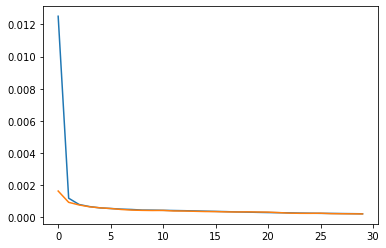

In [11]:
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")


In [12]:
path = r"data_2d"
data_df = pd.read_csv(os.path.join(path, "file_info.csv"))

data_df = data_df[data_df["Max_Value"] > 300]

scale = {'x_min': data_df["Min_Value"].min(), "x_max": data_df["Max_Value"].max()}

train_split = 0.7
val_split = 0.15
test_split = 0.15

listIDs = data_df['File_Name'].tolist()

random.seed(333)
random.shuffle(listIDs)

trainIDs = listIDs[:int(round(train_split * len(listIDs)))]
valIDs = listIDs[int(round(train_split * len(listIDs))):int(round((train_split + val_split) * len(listIDs)))]
testIDs = listIDs[int(round((train_split + val_split) * len(listIDs))):]

test_df = data_df[data_df['File_Name'].isin(testIDs)]
weights="best_model.pth"

encoder = ConvEncoder(num_channels=64, kernel_size=5, strides=1, pooling=2)
decoder = ConvDecoder(num_channels=64, kernel_size=5, strides=2)
model = Autoencoder(encoder, decoder)

In [13]:
test_df

,File_Name,Min_Value,Max_Value,Mean_Value
1,img_0_slice_1.npy,-1000,1662,-619.778738
5,img_0_slice_102.npy,-1000,1630,-699.087481
9,img_0_slice_106.npy,-1000,1552,-694.988512
21,img_0_slice_117.npy,-1000,1649,-688.440663
25,img_0_slice_120.npy,-1000,1525,-688.518650
...,...,...,...,...
3823,img_9_slice_81.npy,-1000,2320,-640.063775
3832,img_9_slice_9.npy,-1000,3000,-597.544894
3833,img_9_slice_90.npy,-1000,2683,-636.928031
3836,img_9_slice_93.npy,-1000,2549,-639.671406


In [14]:
def load_model(weights_path, encoder, decoder):
    model = Autoencoder(encoder, decoder)
    model.load_state_dict(torch.load(weights_path, map_location=torch.device('cuda:2')))
    model.eval()
    return model

def preprocess_image(image_array):
    if image_array.dtype != np.float32:
        image_array = image_array.astype(np.float32)
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    image_tensor = transform(image_array)
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    return image_tensor

def get_prediction(model, image_tensor, device):
    model.to(device)
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)
    return output.cpu().numpy()

In [15]:
def main():
    idx=np.random.randint(0, len(test_df))
    image_path = os.path.join(path, test_df.iloc[idx]["File_Name"])

    image_array = np.load(image_path)  # Load your image array here
    weights = "best_model.pth"

    encoder = ConvEncoder(num_channels=64, kernel_size=5, strides=1, pooling=2)
    decoder = ConvDecoder(num_channels=64, kernel_size=5, strides=2)
    model = load_model(weights, encoder, decoder)

    image_tensor = preprocess_image(image_array)

    device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
    prediction = get_prediction(model, image_tensor, device)

    return np.squeeze(prediction) , np.squeeze(image_array)

In [22]:
prediction , ground_truth=main()

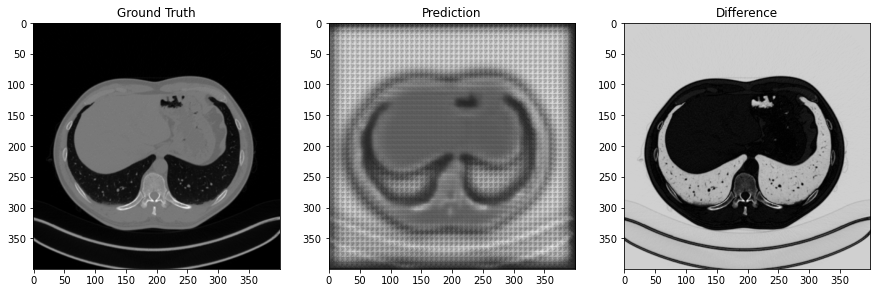

In [23]:
difference = np.abs(prediction - ground_truth)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(ground_truth, cmap='gray')
axs[0].set_title('Ground Truth')

axs[1].imshow(prediction, cmap='gray')
axs[1].set_title('Prediction')

axs[2].imshow(difference, cmap='gray')
axs[2].set_title('Difference')

plt.show()